In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import apriori, association_rules, fpgrowth
from mlxtend.preprocessing import TransactionEncoder
import warnings
warnings.filterwarnings('ignore')

In [59]:
full_data = pd.read_csv('F:/Muthu_2023/Personal/NextStep/MLProjects/Analytics/Datasets/BigBasket/BB_Categorised.csv')
full_data.rename(columns={'Order': 'OrderID', 'Description': 'ProductID', 'Created On': 'OrderDate', 'Member': "CustID"}, inplace=True)
df = full_data[['OrderID', 'ProductID', 'Category', 'Sub Category', 'OrderDate', 'CustID']]
df.head()

,OrderID,ProductID,Category,Sub Category,OrderDate,CustID
0,6468572,Other Sauces,"Oil, Masala and Sauces",Sauces,22-09-2014,M09736
1,6468572,Cashews,Food,Nuts,22-09-2014,M09736
2,6468572,Other Dals,"Rice, Dhal and Flour",Dhal,22-09-2014,M09736
3,6468572,Namkeen,Snacks and Biscuits,Snacks,22-09-2014,M09736
4,6468572,Sugar,"Oil, Masala and Sauces",Masala,22-09-2014,M09736


In [60]:
df['OrderDate'] = pd.to_datetime(df['OrderDate'], dayfirst=True)
df['OrderMonth'] = df['OrderDate'].dt.month
df['OrderDay'] = df['OrderDate'].dt.dayofweek

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_608\2601651338.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['OrderDate'] = pd.to_datetime(df['OrderDate'], dayfirst=True)


In [61]:
df

,OrderID,ProductID,Category,Sub Category,OrderDate,CustID,OrderMonth,OrderDay
0,6468572,Other Sauces,"Oil, Masala and Sauces",Sauces,2014-09-22,M09736,9,0
1,6468572,Cashews,Food,Nuts,2014-09-22,M09736,9,0
2,6468572,Other Dals,"Rice, Dhal and Flour",Dhal,2014-09-22,M09736,9,0
3,6468572,Namkeen,Snacks and Biscuits,Snacks,2014-09-22,M09736,9,0
4,6468572,Sugar,"Oil, Masala and Sauces",Masala,2014-09-22,M09736,9,0
...,...,...,...,...,...,...,...,...
62136,8381435,Organic F&V,Vegetables and Fruits,Fruits,2013-11-16,M64379,11,5
62137,8381435,Exotic Vegetables,Vegetables and Fruits,Vegetables,2013-11-16,M64379,11,5
62138,8381435,Shoe Polish,Personal Care,Other,2013-11-16,M64379,11,5
62139,8381435,Organic Dals & Pulses,"Rice, Dhal and Flour",Dhal,2013-11-16,M64379,11,5


# LRFMP Analysis

In [95]:
cust_df = pd.DataFrame()

# Length of membership
cust_df['FirstOrder'] = df[['OrderDate', 'CustID']].groupby(by='CustID').min()
cust_df['LastOrder'] = df[['OrderDate', 'CustID']].groupby(by='CustID').max()
cust_df['Length'] = cust_df['LastOrder'] - cust_df['FirstOrder']
cust_df['Length'] = cust_df['Length'].dt.days

# Recent Transaction
LastTxDate = df['OrderDate'].max()
cust_df['Recency'] = LastTxDate - cust_df['LastOrder']
cust_df['Recency'] = cust_df['Recency'].dt.days

# Frequency of Purchase
cust_df['Freq'] = df[['OrderID', 'CustID']].drop_duplicates().groupby(by='CustID').count()

# No of Quantites Purchased
cust_df['Monetary'] = df[['OrderID', 'CustID']].groupby(by='CustID').count()

# The average interval between days which transaction(s) occurred
tempdf = df[['CustID', 'OrderDate']].drop_duplicates().sort_values(by=['CustID', 'OrderDate'])
tempdf['diff'] = tempdf.groupby('CustID').diff(1)
cust_df['Periodicity'] = tempdf[['CustID', 'diff']].groupby('CustID').mean()
cust_df['Periodicity'] = cust_df['Periodicity'].dt.days

# No of Unique Products Purchased
tempdf = df[['CustID', 'ProductID']]
tempdf = tempdf.drop_duplicates()
cust_df['UniqueProd'] = tempdf.groupby('CustID').count()
cust_df.reset_index(inplace=True)
cust_df.drop(['FirstOrder', 'LastOrder'], axis=1, inplace=True)

In [99]:
cust_df.iloc[:,1:]

,Length,Recency,Freq,Monetary,Periodicity,UniqueProd
0,966,5,132,493,7,69
1,718,7,55,638,13,62
2,698,1,105,463,6,63
3,510,5,62,626,8,58
4,623,87,39,556,17,55
...,...,...,...,...,...,...
101,696,1,79,412,9,50
102,697,0,66,483,10,60
103,697,3,73,402,9,52
104,909,1,78,594,11,26


C:\Users\ADMIN\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


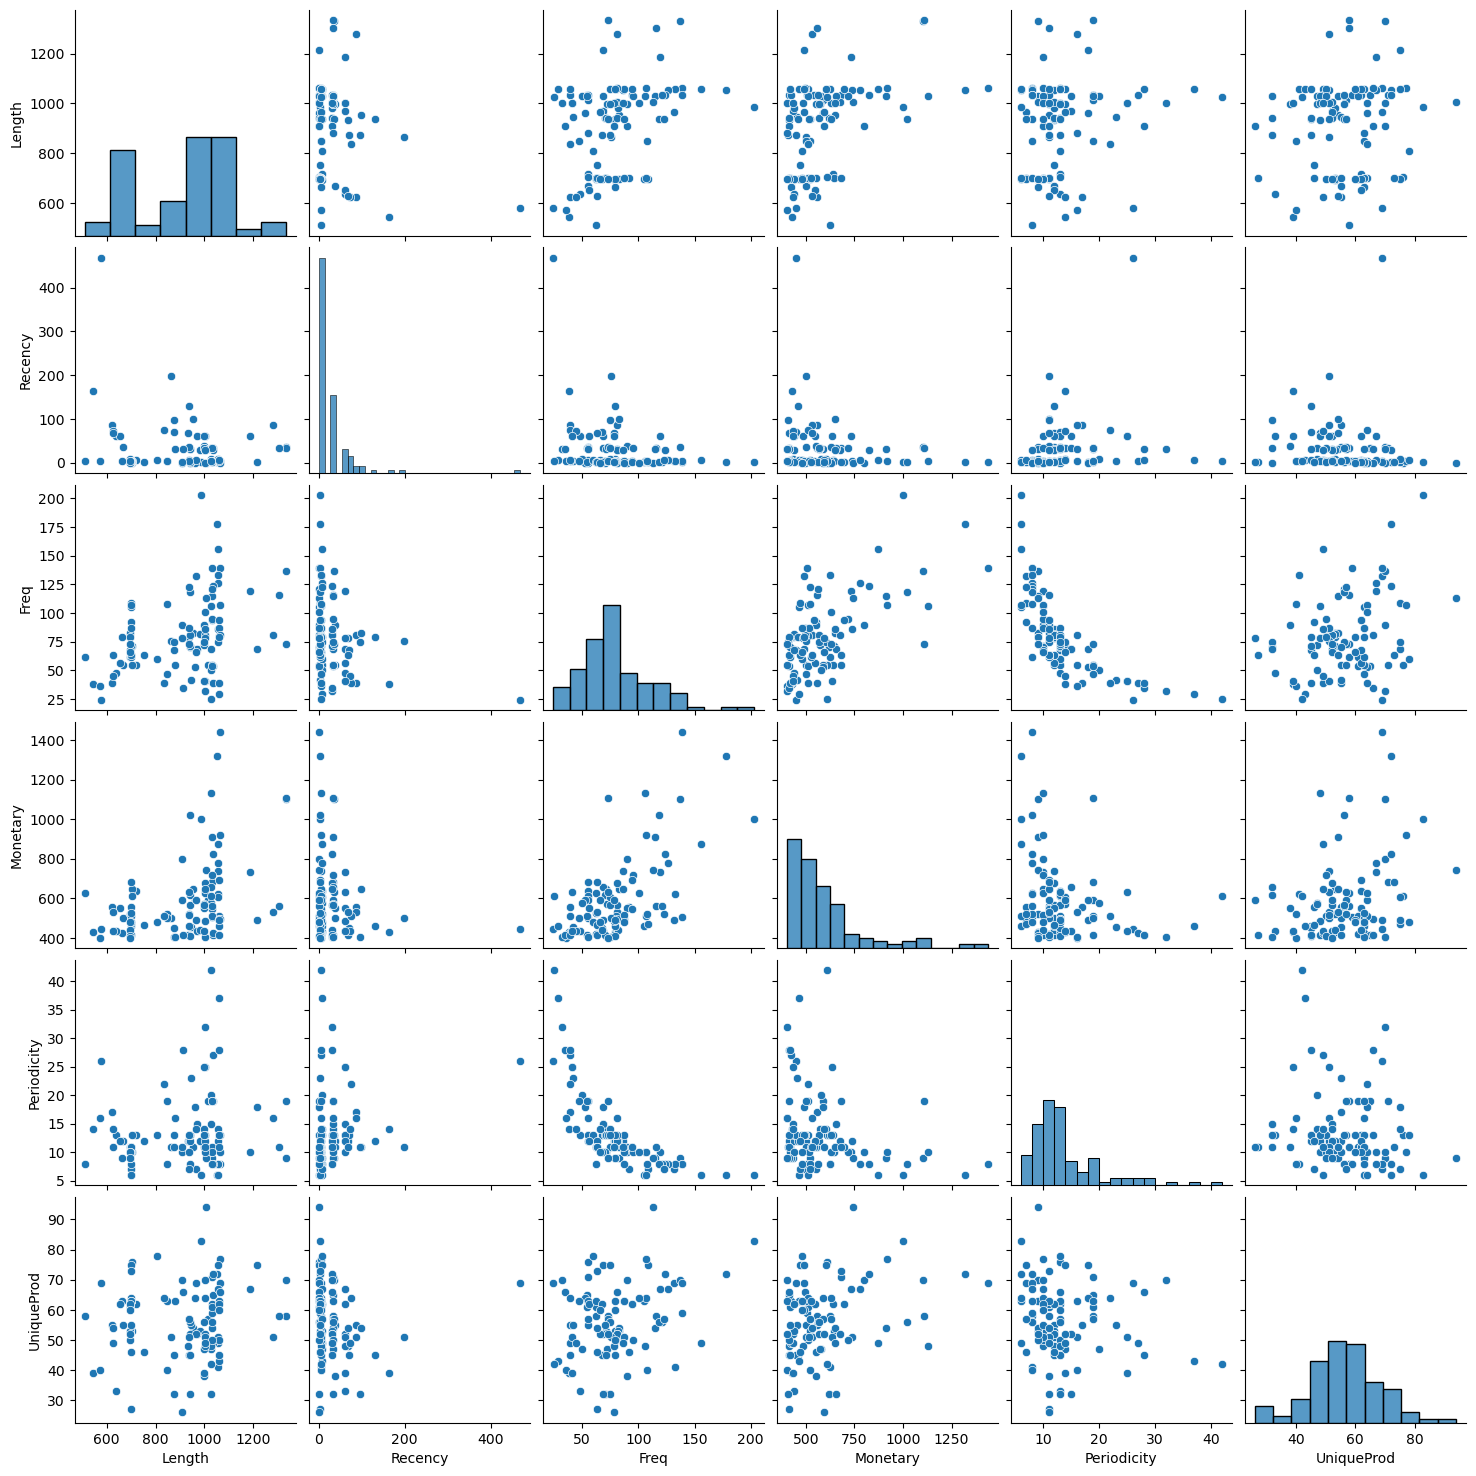

In [103]:
sns.pairplot(cust_df.iloc[:,1:])

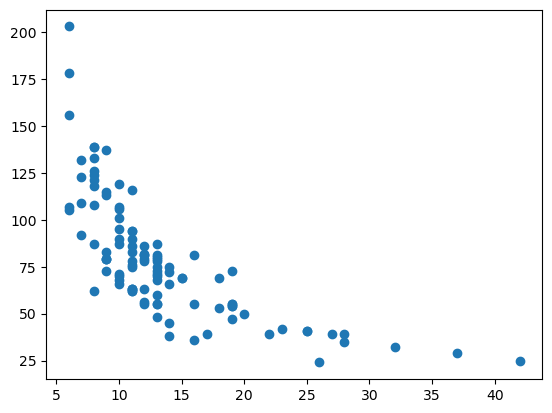

In [106]:
plt.scatter(cust_df.iloc[:,5], cust_df.iloc[:,3])

In [112]:
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

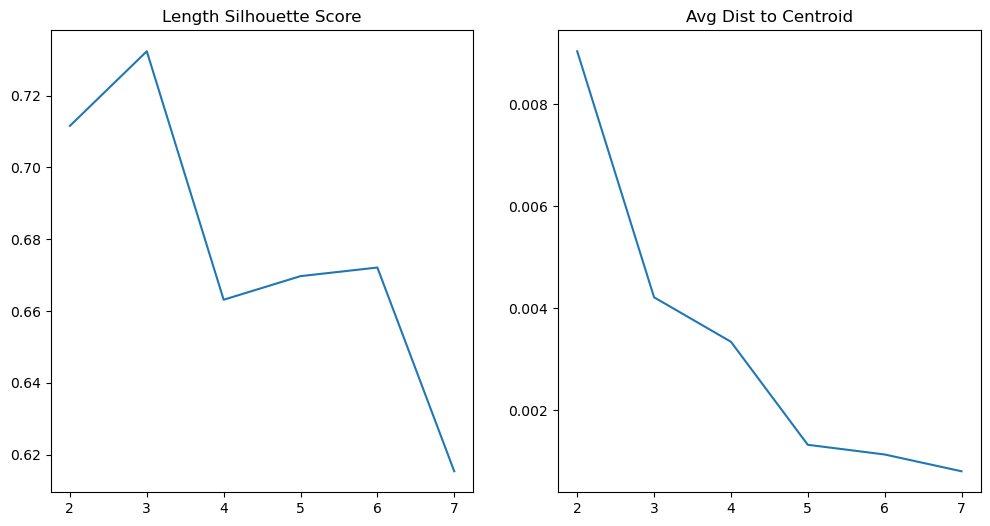

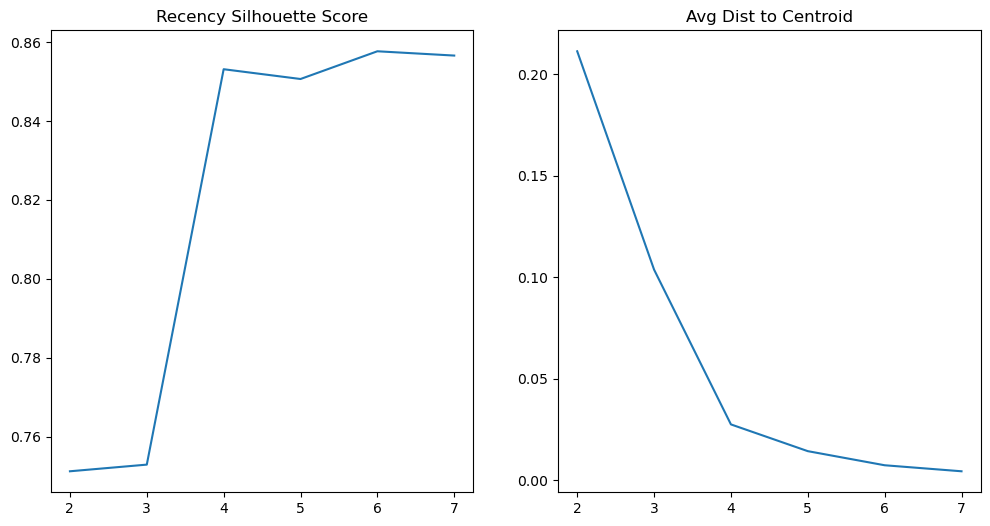

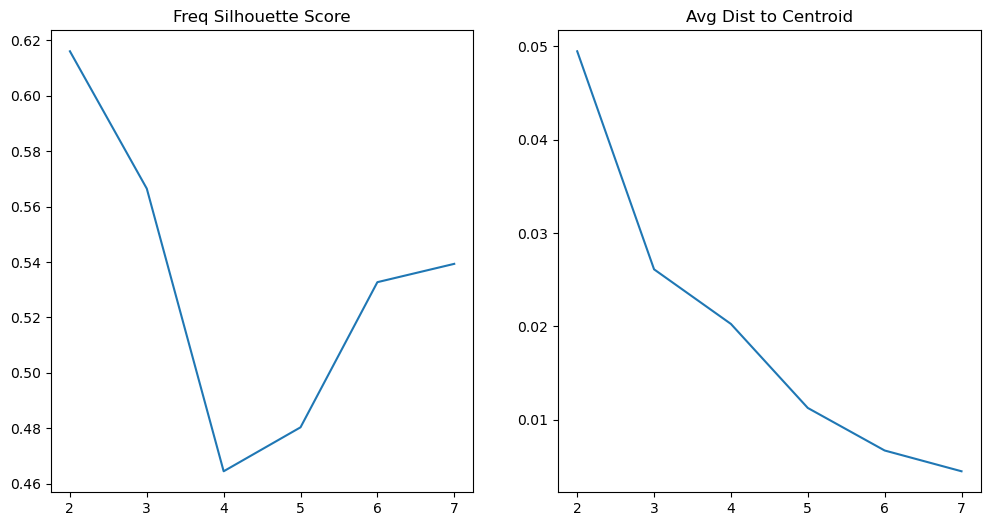

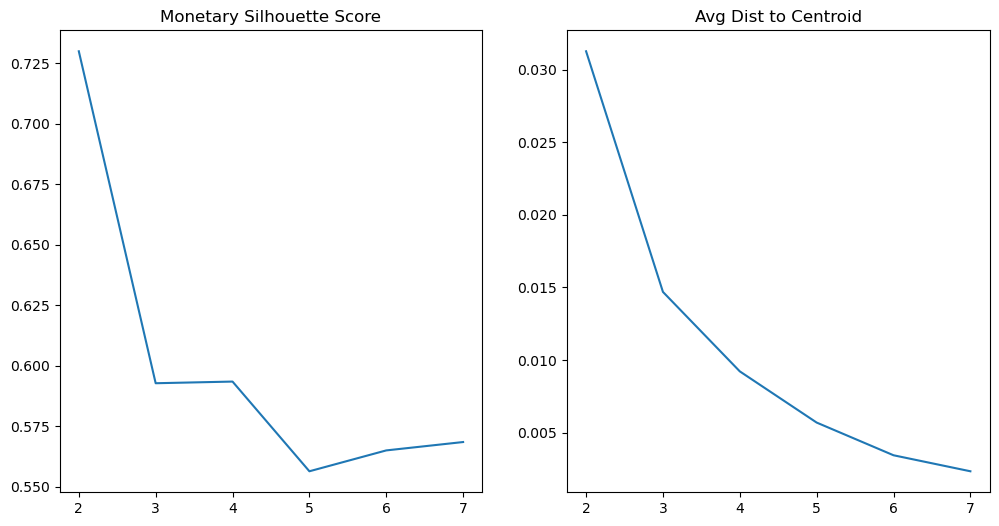

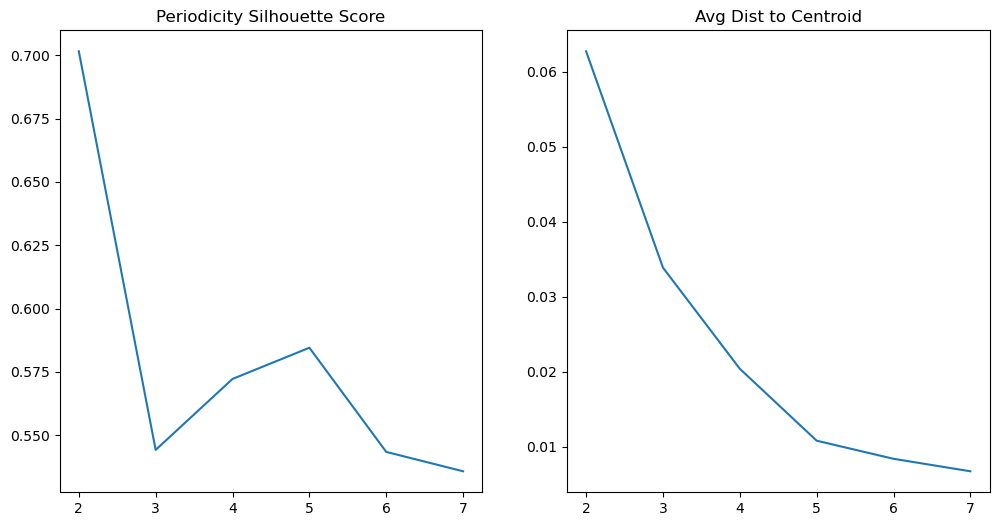

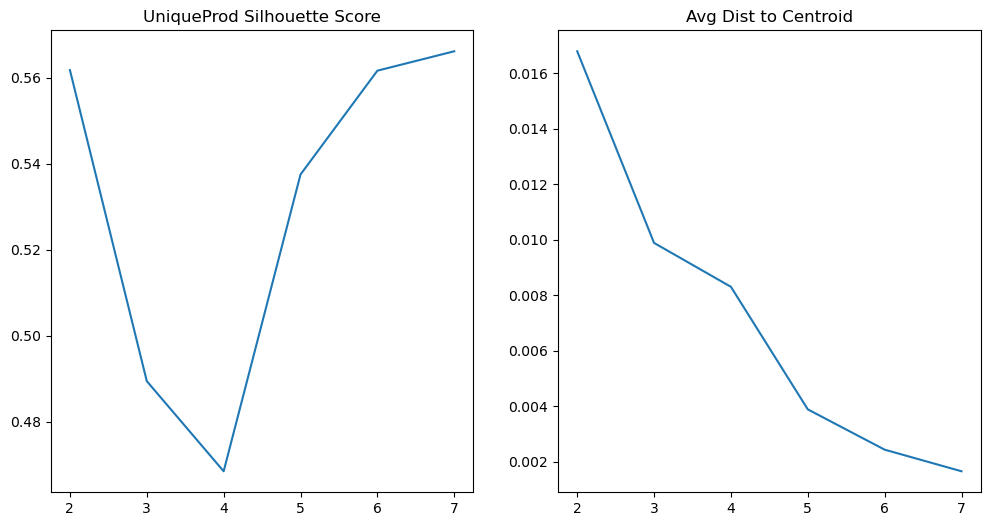

In [327]:
models = []
col_list = cust_df.columns
for i in range(6):
    m = i+1
    n = m+1
    x = np.array(cust_df.iloc[:,m:n])
    if m == n+1:
        x = x.reshape(-1,1)
        xNorm = preprocessing.normalize(x, axis=0)
    else:
        xNorm = preprocessing.normalize(x, axis=0)
    scores = []
    sse = {}
    for k in range(2,8):
        kmean = KMeans(n_clusters=k, random_state=0, n_init='auto').fit(xNorm)
        score = silhouette_score(xNorm, kmean.labels_, metric = 'euclidean')
        models.append([col_list[i+1], kmean, score])
        scores.append(score)
        sse[k] = kmean.inertia_
    plt.figure(figsize=(12,6))
    plt.subplot(1, 2, 1)
    plt.plot(np.arange(2, len(scores)+2), scores)
    plt.title(col_list[i+1] + ' Silhouette Score')
    plt.subplot(1, 2, 2)
    plt.plot(sse.keys(), sse.values())
    plt.title('Avg Dist to Centroid')

In [323]:
kmean.inertia_

0.0016532705317241455

In [314]:
models = np.array(models)
score = np.where(models[:,0]=='Length', models[:,2], -1)
kmean = np.where(models[:,0]=='Length', models[:,1], -1)

Text(0.5, 1.0, 'Avg Dist to Centroid')

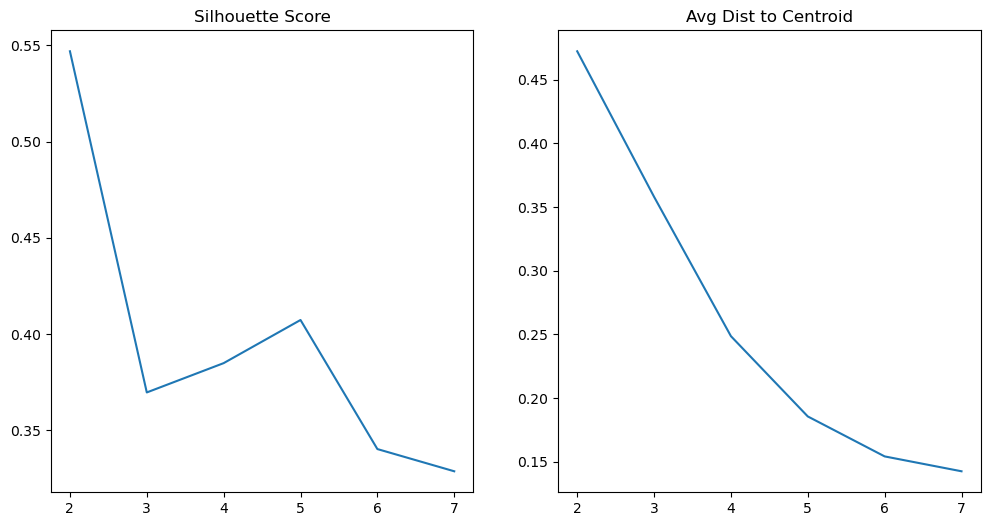

In [276]:
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.plot(np.arange(2, len(score)+2), score)
plt.title('Silhouette Score')
plt.subplot(1, 2, 2)
plt.plot(sse.keys(), sse.values())
plt.title('Avg Dist to Centroid')

(array([49.,  0., 17.,  0.,  0.,  3.,  0., 15.,  0., 21.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

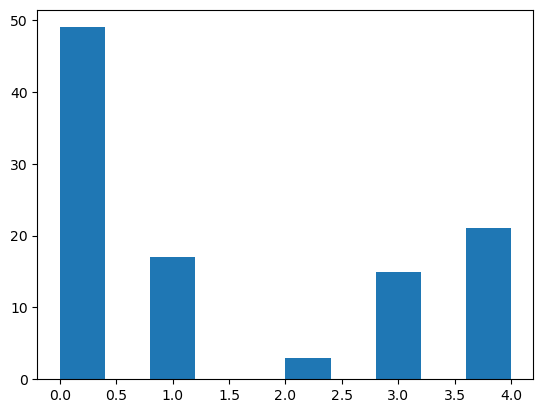

In [277]:
plt.hist(models[3].labels_)

(array([62.,  0.,  0., 24.,  0.,  0.,  3.,  0.,  0., 16.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

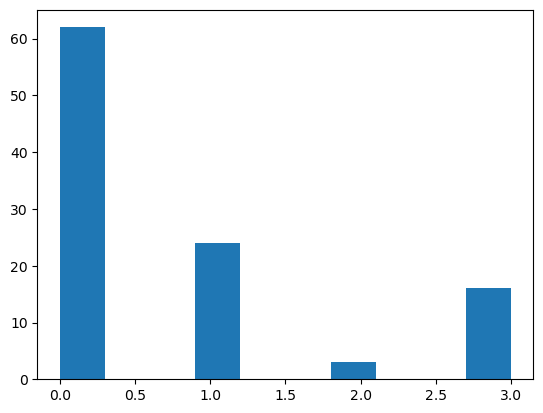

In [278]:
plt.hist(models[2].labels_)

(array([62.,  0.,  0.,  0.,  0., 24.,  0.,  0.,  0., 19.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

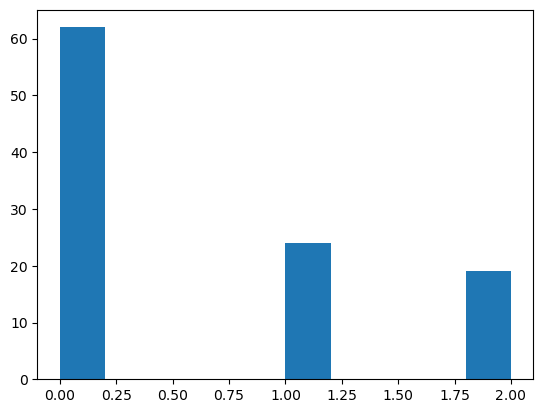

In [279]:
plt.hist(models[1].labels_)

In [280]:
models[2].labels_

array([1, 0, 0, 0, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 1, 3, 1, 3,
       1, 0, 1, 1, 0, 3, 0, 0, 1, 1, 0, 1, 3, 0, 0, 0, 1, 3, 2, 0, 1, 1,
       1, 1, 0, 0, 1, 0, 3, 0, 1, 0, 0, 0, 3, 0, 1, 3, 0, 2, 3, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 3, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 3, 0, 0, 3, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 3])

In [281]:
cust_df[models[2].labels_ == 2]

,CustID,Length,Recency,Freq,Monetary,Periodicity,UniqueProd,Cluster
5,M12127,545,164,38,431,14,39,0
41,M40184,937,130,79,460,12,45,3
62,M50038,865,198,76,503,11,51,1


In [154]:
cust_df['Recency'].max()

469

<Axes: >

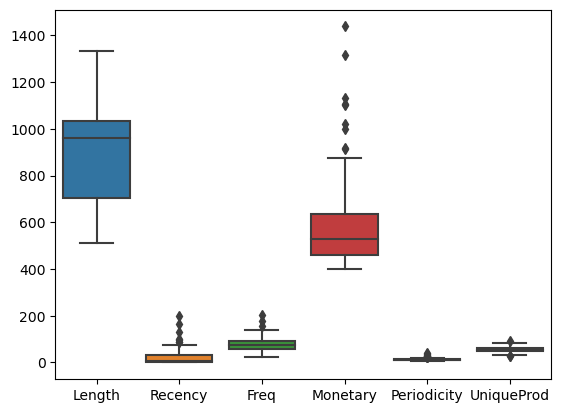

In [162]:
sns.boxplot(cust_df.iloc[:,1:])

In [163]:
cust_df['Cluster'] = models[2].labels_

In [164]:
cust_df

,CustID,Length,Recency,Freq,Monetary,Periodicity,UniqueProd,Cluster
0,M04158,966,5,132,493,7,69,1
1,M08075,718,7,55,638,13,62,2
2,M09303,698,1,105,463,6,63,0
3,M09736,510,5,62,626,8,58,2
4,M12050,623,87,39,556,17,55,2
...,...,...,...,...,...,...,...,...
101,M90375,696,1,79,412,9,50,1
102,M91098,697,0,66,483,10,60,0
103,M96365,697,3,73,402,9,52,1
104,M99030,909,1,78,594,11,26,0


In [166]:
cust_cluster = cust_df.iloc[:,1:].groupby('Cluster').mean()

In [180]:
cust_mean = cust_df.iloc[:,1:-1].mean()

In [171]:
test['Length']

913.3047619047619

In [182]:
cust_profile = cust_cluster.copy()
col = cust_cluster.columns
for i in range(len(col)):
    cust_profile[cust_cluster[col[i]] >= cust_mean[col[i]]] = 1
    cust_profile[cust_cluster[col[i]] < cust_mean[col[i]]] = 0
cust_profile

,Length,Recency,Freq,Monetary,Periodicity,UniqueProd
Cluster,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,1.0,1.0,1.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0


In [183]:
cust_cluster

,Length,Recency,Freq,Monetary,Periodicity,UniqueProd
Cluster,,,,,,
0,832.807692,25.461538,80.653846,585.153846,10.807692,55.384615
1,901.970588,20.470588,77.294118,531.970588,13.264706,54.264706
2,896.421053,18.842105,99.263158,866.421053,10.315789,63.105263
3,1020.961538,34.615385,67.384615,458.884615,17.692308,54.076923


In [179]:
test

Length         913.304762
Recency         24.914286
Freq            79.647619
Monetary       587.561905
Periodicity     13.219048
UniqueProd      56.095238
dtype: float64

# Apply PCA

In [185]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

In [282]:
n_comp = n-m
pl = Pipeline([('Scaling', StandardScaler()),
             ('PCA', PCA(n_components=n_comp))])

In [283]:
pl.fit(cust_df.iloc[:,m:n])

Pipeline(steps=[('Scaling', StandardScaler()), ('PCA', PCA(n_components=4))])

In [284]:
pca_trans = pl.transform(cust_df.iloc[:,m:n])

In [197]:
pl['PCA'].components_

array([[ 0.2281171 , -0.25581555,  0.5823196 ,  0.49194854, -0.41872034,
         0.3410683 , -0.09877858],
       [ 0.62782625,  0.03546659, -0.02511191,  0.19000935,  0.45464573,
         0.10502321,  0.59170055],
       [ 0.17089092,  0.7472684 ,  0.24155158,  0.16451689, -0.2550869 ,
        -0.51144585,  0.01808526],
       [ 0.29229524, -0.42316152, -0.05270426,  0.26329954,  0.26699635,
        -0.61053528, -0.46835142],
       [ 0.04861518,  0.43408664, -0.25140714,  0.35756691,  0.33481816,
         0.46060227, -0.54211443]])

In [285]:
print(pl['PCA'].explained_variance_ratio_)

[0.49499611 0.24365254 0.16435003 0.09700132]


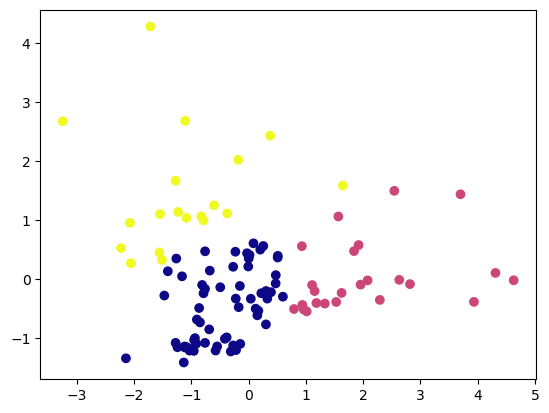

In [286]:
plt.scatter(pca_trans[:,0], pca_trans[:,1],  c=models[1].labels_, cmap='plasma')

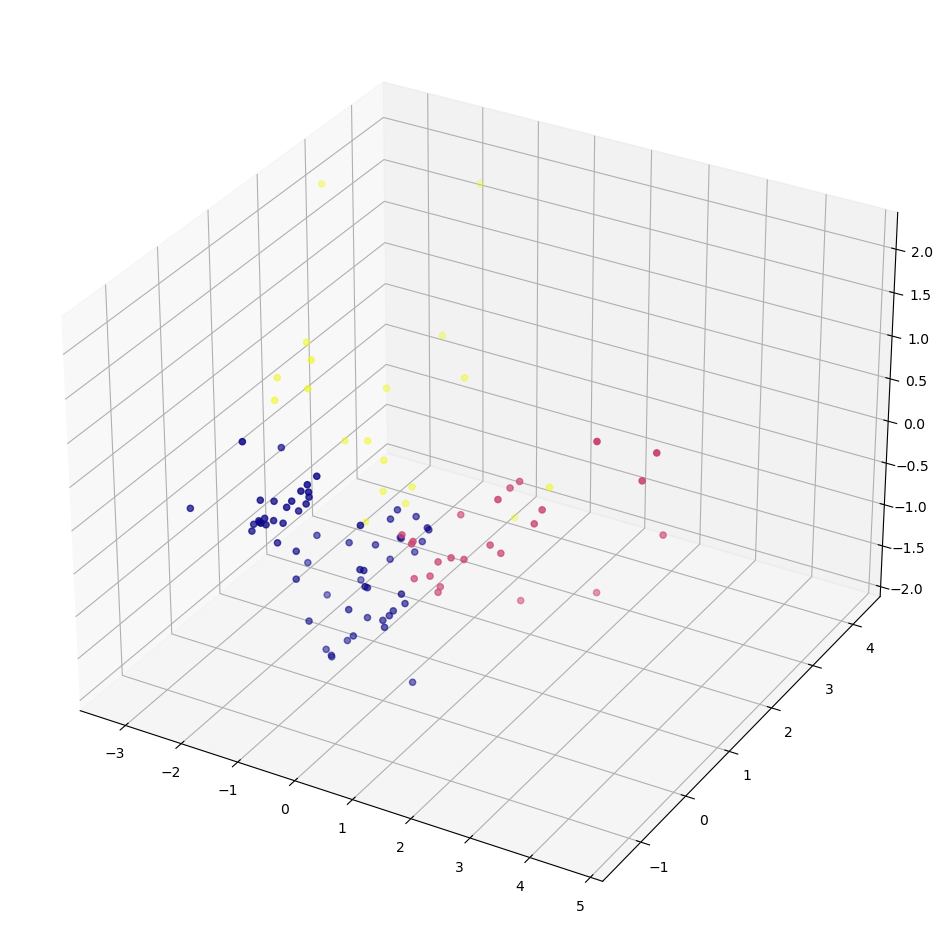

In [287]:
fig = plt.figure(figsize=(12,16))
 
# syntax for 3-D projection
ax = plt.axes(projection ='3d')
ax.scatter(pca_trans[:,0], pca_trans[:,1],pca_trans[:,2],  c=models[1].labels_, cmap='plasma')

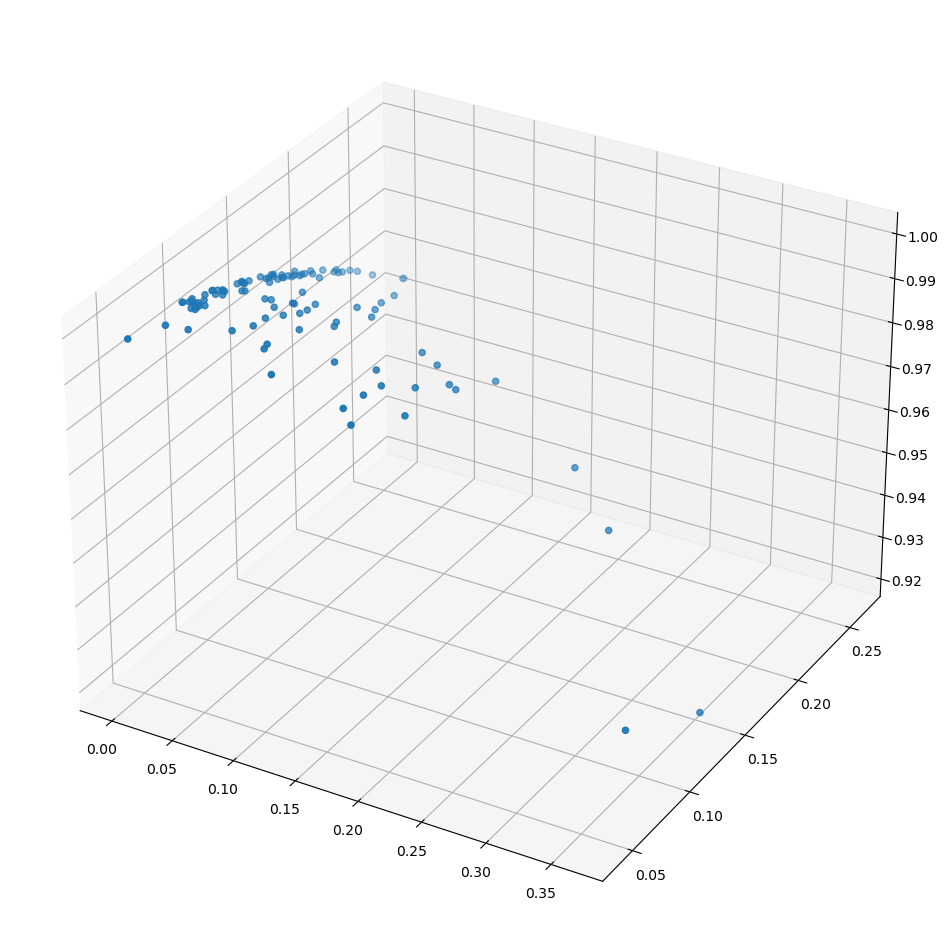

In [254]:
fig = plt.figure(figsize=(12,16))
 
# syntax for 3-D projection
ax = plt.axes(projection ='3d')
ax.scatter(xNorm[:,0], xNorm[:,1],xNorm[:,2], cmap='plasma')